This is based on Francesca's picktime and grid search code - see her github for alt version

In [43]:
import yaml
import csv
import eqcorrscan
from eqcorrscan import Tribe
from time import time
import obspy
from obspy import UTCDateTime, Trace
import pandas as pd
from glob import glob
import numpy as np
from obspy.signal.cross_correlation import *
import matplotlib.pyplot as plt
from geopy import distance

### Find Picktimes

read config file for parameters

In [54]:
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']
grid_length = float(config['grid_length'])
grid_height = float(config['grid_height'])
step = config['step']
t_step = config['t_step']
vs_min = config['vs_min']
vs_max = config['vs_max']
vs_step = config['vs_step']
volc_lat_lon = config['volc_lat_lon']

vv = config['vv']

Read REDpy Catalogs and Volcano Metadata File

In [45]:
Baker = pd.read_csv(readdir+'Baker_catalog.csv')
Hood = pd.read_csv(readdir+'Hood_catalog.csv')


St_Helens = pd.read_csv(readdir+'MountStHelens_catalog.csv')

# Combining borehole and local catalogs with St_Helens

Helens_Borehole = pd.read_csv(readdir+'MSHborehole_catalog.csv')
Helens_Borehole['Clustered'] += 2000 
# Cluster 0 in Helens_Borehole is now Cluster 2000 in St_Helens
Helens_Local = pd.read_csv(readdir+'MSHlocal_catalog.csv')
Helens_Local['Clustered'] += 3000
# Cluster 0 in Helens_Local is now Cluster 3000 in St_Helens

# Use St_Helens to access all three St Helens catalogs
St_Helens = pd.concat([St_Helens,Helens_Borehole,Helens_Local])
clid = np.unique(St_Helens['Clustered'].values.tolist()) #find the largest cluster ID for a volcano to set range
print(clid[-1])

Newberry = pd.read_csv(readdir+'Newberry_catalog.csv')
Rainier = pd.read_csv(readdir+'Rainier_catalog.csv')

volc_md = pd.read_csv(readdir+'Volcano_Metadata.csv')
# read metadata file to create dataframe of labels

3523


Associate networks and stations

In [46]:
volc_md['netsta'] = volc_md['Network'].astype(str)+'.'+volc_md['Station'].astype(str)

Create Lists of Stations for Each Volcano Using volc_md

In [47]:
Baker_sta = volc_md[volc_md['Volcano_Name'] == 'Baker']['netsta'].values.tolist()
Hood_sta = volc_md[volc_md['Volcano_Name'] == 'Hood']['netsta'].values.tolist() 
St_Helens_sta = volc_md[volc_md['Volcano_Name'] == 'St_Helens']['netsta'].values.tolist()
Newberry_sta = volc_md[volc_md['Volcano_Name'] == 'Newberry']['netsta'].values.tolist() 
Rainier_sta = volc_md[volc_md['Volcano_Name'] == 'Rainier']['netsta'].values.tolist()

Create Lists of Volcano Information

In [48]:
volc_list = [Baker,Hood,Newberry,Rainier,St_Helens] # list of dataframes for each volcano
volc_list_names = ['Baker','Hood','Newberry','Rainier','St_Helens'] # list of names of each volcano
volc_sta = [Baker_sta,Hood_sta,Newberry_sta,Rainier_sta,St_Helens_sta] # lists of stations connected to respective volcanoes

Define pick_time

In [49]:
def pick_time(ref_env, data_env_dict, st): 
    est_picktimes=str(st[0].stats.starttime)
    xcor = correlate(data_env_dict,ref_env,int(50*fs))
    index = np.argmax(xcor)
    cc = round(xcor[index],9) #correlation coefficient
    shift = 50*fs-index #how much it is shifted from the reference envelope
    #print(shift, cc, key)
    relative_p = shift/fs
    p = UTCDateTime(est_picktimes) + shift/fs  # p is the new phase pick for each station
    return p, shift, relative_p
def get_cmap(n, name='viridis'): #hsv
#     Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.
    return plt.cm.get_cmap(name, n)

Define location

In [50]:
# define function to predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# define function to compute residual sum of squares
def error(synth_arrivals,arrivals):
    res = arrivals - synth_arrivals   #make sure arrivals are in the right order, maybe iterate through keys
    res_sqr = res**2
    rss = np.sum(res_sqr)
    return rss

# define function to iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)): 
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                for m in range(len(vs)): #parameterize velocity
                    synth_arrivals = []
                    for h in range(len(sta_x)):
                        tt = travel_time(t0[i],x_vect[j],y_vect[k],vs[m],sta_x[h],sta_y[h]) 
                    #add vs in nested loop, vector 1000-5000, per cluster to account for p and s waves
                        synth_arrivals.append(tt)
                    rss = error(np.array(synth_arrivals),np.array(arrivals))
                    rss_mat[i,j,k] = rss
    return rss_mat

# define function to convert the location index into latitude and longitude
def location(x_dist, y_dist, start_lat, start_lon):
    bearing = 90-np.rad2deg(np.arctan(y_dist/x_dist))
    dist = np.sqrt((x_dist)**2 + (y_dist)**2)
    d = distance.geodesic(meters = dist)
    loc_lat = d.destination(point=[start_lat,start_lon], bearing=bearing)[0]
    loc_lon = d.destination(point=[start_lat,start_lon], bearing=bearing)[1]
    return loc_lat, loc_lon, d

# define function to find diameter in meters of the error on the location
def error_diameter(new_array):
    min_idx = np.min(new_array[:,1])
    max_idx = np.max(new_array[:,1])
    difference = max_idx-min_idx
    diameter_m = difference*1000
    return diameter_m 

Find picktimes and location

In [55]:
# for vv,v in enumerate(volc_sta): #vv is the number in the list, v is the station list for current volcano
vv=0
v = volc_sta[vv] #not doing a volcano loop
clid = np.unique(volc_list[vv]['Clustered'].values.tolist()) #find the cluster IDs for a volcano to set range
cllen = len(str(clid[-1])) #length of the largest cluster ID, used for zfill
zz = chan[-2:].lower() #the last two letters of channel names (essentially the letters in chan)
#make csv?

with open(homedir+f'/locations/{volc_list_names[vv]}_Template_Locations.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Volcano_Name','netsta','Picktimes','Cluster_ID','Latitude','Longitude',])
    file.close()

for cl in range(13,14):#options: cl in range(0,clid[-1]+1) for specific ranges; cl in clid for all Cluster IDs
    temps_s = {} #empty dictionary that will be filled with the templates for this cluster
    print('------') #print a divider
    print("cluster:",str(cl).zfill(cllen)) #print the cluster ID
    stopwatch0=time() #note the time
    for s in range(0,len(v)): #loop through stations
        net, sta =  v[s].split('.') #add specific network per station

########################################################################    
#                       FINDING PICK TIMES                             #
########################################################################

        # try to read the .tgz/Tribe file
        try:
            T = Tribe().read(*glob(f'{homedir}templates/Volcano_{volc_list_names[vv]}_Network_{net}_Station_{sta}_Channel_*.tgz'))
        except:
            print(f'{net}.{sta} tgz does not exist')
            continue
        for t in T: #for each template in the tgz
            if t.name.endswith(str(cl).zfill(cllen)): #if the template name endswith this cluster
                temps_s[f'{net.lower()}.{t.name}']=t #save to dictionary and include network name
                break

    if len(temps_s) < minsta: #if the number of templates for this cluster is less than minsta (see config)
        print('not enough stations with data for this cluster') #print a reminder
        stopwatch2=time() #note the time
        print(f'{stopwatch2-stopwatch0} s for this cluster') #say how many s to go through this cluster
        continue #move onto the next cluster
        
    data_env_dict = {} #a dictionary of the envelopes for each template stream
    for t in temps_s: #for each saved template (aka each template for this cluster and volc that exists)
        data_envelope = obspy.signal.filter.envelope(temps_s[t].st[0].data) #make an envelope
        data_envelope /= np.max(data_envelope) #average envelope (?)
        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length) #smooth the envelope
        data_env_dict[t] = data_envelope #save the envelope to the dictionary

    pick_times = {} #dictionary of picktimes for each template
    for key in data_env_dict: #for each envelope
        p, shift, relative_p = pick_time(ref_env=data_env_dict[list(data_env_dict.keys())[0]], 
                data_env_dict=data_env_dict[key],st=temps_s[key].st) #calculate picktimes
        pick_times[key] = relative_p #save to dictionary
    print(f'{cl} offsets are {pick_times}') #print pick times relative to first template stream (can be negative)
    
    #arranging picktimes from 0 (earliest station) to later (positive) times
    #will NOT be used for plotting picktimes, but will be used for location
    dif_dict = {} #dictionary of picktimes in reference to earliest picktime (in positive seconds after the earliest picktime)
    max_value = max(pick_times, key=pick_times.get) #get key for max value of pick_times aka the earliest picktime
    for key in pick_times: #for each picktime
        dif = round(abs(pick_times[max_value] - pick_times[key]),4) #max value minus current value
        dif_dict[key] = dif #save to dictionary with the same key as pick_times

    
########################################################################    
#                       PLOTTING PICK TIMES                            #
########################################################################

#     cmap = get_cmap(len(temps_s)) #get cmap aka colors for the plot, see def(get_cmap) for color palette
#     plt.figure(figsize=(10,10)) #set plot size
#     plt.title('aligned templates, vlines are template starts') #plot title
#     for tt,t in enumerate(temps_s): #for every template
#         shift = round(pick_times[t]*fs) #find shift based on picktimes
#         st0 = temps_s[t].st.copy() #make a copy for a reference
#         maxdata = len(temps_s[t].st[0].data[:]) #find maximum length of template stream

#         empty = Trace(np.zeros(shift)) #an empty trace/a trace filled with zeros
#         if shift<0: #if shift is negative
#             temps_s[t].st[0].data[:shift]=st0[0].data[-shift:] #shift to the left
#         if shift>0: #if shift is positive
#             temps_s[t].st[0].data[shift:]=st0[0].data[:-shift] #shift to the right
#             temps_s[t].st[0].data[:shift]=empty.data[:shift] #get rid of leftover data from shift
#         #note: if shift == 0, will be plotting with no shifting
#         plt.plot(temps_s[t].st[0].data[:]/np.max(np.abs(temps_s[t].st[0].data[:]))+2*tt,color=cmap(tt), label=t) #plot stream
#         plt.vlines(shift,ymin=-1,ymax=2*len(temps_s),color=cmap(tt)) #plot line in same color representing the start of the template
#         plt.legend() #show the legend
    
#     first_sta = max(pick_times, key=pick_times.get) #gives you the template name for the first
    #station to get a signal (largest/most positive pick time)
    
########################################################################    
#                         FINDING LOCATION                             #
########################################################################

    # define input parameters
    arrivals = [] #relative picktimes, dif_dict as a list
    sta_lats = [] #station latitudes, from metadata
    sta_lons = [] #station longitudes, from metadata
    netsta_names = [] #list of station names with networks
    for key in dif_dict: #for each station
        arrivals.append(dif_dict[key]) #append pick time to arrivals
        
        #finding station name
        if not key.endswith(str(cl).zfill(cllen)): #if the wrong cluster id
            print('template name does not match cluster ID') #print an error
            continue #and skip the rest
        if key.endswith(f'{zz}rp{volc_list_names[vv][:2].lower()}{str(cl).zfill(cllen)}'): #if the key has a channel name in it (the 'hz')
            md_netsta = key[:-(7+cllen)] #remember the stuff before channel name rpvo and cluster ID
        if not key.endswith(f'{zz}rp{volc_list_names[vv][:2].lower()}{str(cl).zfill(cllen)}'): #if the key has NO channel name in it
            md_netsta = key[:-(4+cllen)] #remember the stuff before rpvo and cluster ID
#         print(md_netsta)
        lat = volc_md[volc_md['netsta']==md_netsta.upper()]['Latitude'].values.tolist() #get latitude from metadata
        sta_lats.append(lat[0]) #append
        
        lon = volc_md[volc_md['netsta']==md_netsta.upper()]['Longitude'].values.tolist() #get longitude form metadata
        sta_lons.append(lon[0]) #append
        
        netsta_names.append(md_netsta.upper()) # make list of station names


    # define grid origin in lat,lon
    
    #finding bottom left corner of grid map
    lat_start = volc_lat_lon[volc_list_names[vv]][0] - (grid_length/222000) #volcano lat minus half of grid length in decimal lat long
    lon_start = volc_lat_lon[volc_list_names[vv]][1] - (grid_height/222000) #volcano long minus half of grid height in decimal lat long
        
    #station lat lons to x y
    sta_x = []
    sta_y = []
    for i in range(len(sta_lats)):
        x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
        y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
        sta_x.append(x_dist)
        sta_y.append(y_dist)

    # set grid points
    x_vect = np.arange(0, grid_length, step)
    y_vect = np.arange(0, grid_height, step)
    t0 = np.arange(0,np.max(arrivals),t_step)
    vs = np.arange(vs_min,vs_max,vs_step)

    print('yo')
    # carry out the gridsearch
    rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals)
    print('here')
    # find lowest error lat, lon, and origin time
    loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)
    
    # find the lat and lon of the location index
    loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
    err_thr = np.min(np.log10(rss_mat))+.05
    thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
    diameter = error_diameter(thr_array)
    
    print('location lat lon',loc_lat,loc_lon)

    # plot a spatial map of error for lowest-error origin time
#     fig,ax = plt.subplots()
#     ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
#     im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,grid_length,0,grid_height])
#     fig.colorbar(im)
#     plt.show()
    
    row = [volc_list_names[vv],' '.join(netsta_names),' '.join([str(i) for i in arrivals]),cl,loc_lat,loc_lon]
    with open(homedir+f'/locations/{volc_list_names[vv]}_Template_Locations.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)
        file.close()
    
    stopwatch1=time() #note the time
    print(f'{stopwatch1-stopwatch0} s for this cluster') #print time it took to go through this cluster
    
    #write into csv relative picktimes in seconds after first_sta, probably list separated by 
    #spaces, like how stations are saved in events, make sure index is same for the template 
    #name and picktime

------
cluster: 013
13 offsets are {'cn.vdbehzrpba013': 0.0, 'uw.mbwehzrpba013': 10.65, 'uw.passhhzrpba013': 2.975, 'uw.shukbhzrpba013': 7.2}
yo
here
location lat lon 48.88671231251719 -121.90693981282588
13.504610061645508 s for this cluster


Plot locations once gathered

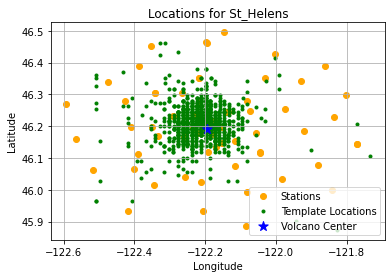

In [39]:
#so far, just plotting stations around the volcano in a basic way to visualize any possible station bias

vv=4 #looking at volc_list[vv]
loc_df = pd.read_csv(homedir+f'/locations/{volc_list_names[vv]}_Template_Locations.csv') #get locations
loc_lats = loc_df['Latitude'].values.tolist() #get a list of latitudes for template locations
loc_lons = loc_df['Longitude'].values.tolist() #get a list of longitudes for template locations

stas_lat = volc_md[volc_md['Volcano_Name']==volc_list_names[vv]]['Latitude'].values.tolist() #get latitude for stations at this volcano
stas_lon = volc_md[volc_md['Volcano_Name']==volc_list_names[vv]]['Longitude'].values.tolist() #get latitude for stations at this volcano

fig, ax = plt.subplots()

# for sta_m in stas_map: #for each station
#     lat = volc_md[volc_md['netsta']==sta_m]['Latitude'].values.tolist()[0] #find the latitude
#     lon = volc_md[volc_md['netsta']==sta_m]['Longitude'].values.tolist()[0] #find the longitude
ax.scatter(stas_lon,stas_lat,marker='o',color='orange',label='Stations') #plot the station
    
# for L in range(0,len(loc_lats)): #for each location
ax.scatter(loc_lons,loc_lats,marker='.',color='green',label='Template Locations') #plot the location
    
v_lat = volc_lat_lon[volc_list_names[vv]][0] #find the volcano latitude
v_lon = volc_lat_lon[volc_list_names[vv]][1] #find the volcano longitude
ax.scatter(v_lon,v_lat,marker='*',color='blue',s=100,label='Volcano Center') #plot the volcano
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Locations for {volc_list_names[vv]}')
ax.legend()

plt.grid()
plt.show()